# Detecting Helicopter Circling in Images

This notebook started as a copy of the lesson 1 notebook in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course. I have just started, yet within the first couple of lessons, I was able to get real results of my own.

I've retained much of the descriptive text and code from that class -- so this work is mainly that of Howard's, and not mine.

Running the code in this notebook -- and the class -- will require some setup, [which is described here](https://course.fast.ai/index.html).

Also you'll need the images I used, which are in this repo as `choppers.zip`.

For more of my process here, see [this blog post](https://qz.ai/spotting-circling-helicopters/).

-- John Keefe

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [3]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [4]:
np.random.seed(2)


In [5]:
path = Path('/home/ubuntu/data/choppers/')

In [6]:
path.ls()

[PosixPath('/home/ubuntu/data/choppers/export.pkl'),
 PosixPath('/home/ubuntu/data/choppers/1'),
 PosixPath('/home/ubuntu/data/choppers/0'),
 PosixPath('/home/ubuntu/data/choppers/models')]

In [7]:
tfms = None  # note: Transformations seem best suited for real-world pics; so I turned this off.

# data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=600)

### ^^ The class code assumes the train/valid split has already been done and is in folders.
### So I modified it using the data_block api https://docs.fast.ai/data_block.html

np.random.seed(2) # ensures the same validation set every time, so can compare changes 

data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()              #How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=600)       #Data augmentation? -> use tfms with a size of 600, because they all are
        .databunch(bs=16))

### Ah. Later we learn another way to do the same thing:

# data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [ ]:
data.show_batch(rows=3)

(Here's my original output, which I'm loading from a folder for better display in Github:)

![sorted the images](notebook-images/image-1.png)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories.

We will train for 4 epochs (4 cycles through all our data).

In [30]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.900236,0.656154,0.361111,00:09
1,0.620992,0.605561,0.416667,00:09
2,0.519490,0.494210,0.250000,00:09
3,0.425946,0.286636,0.111111,00:09


## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [ ]:
interp.plot_top_losses(9)

(Here's that original image)
![what the computer sees](notebook-images/image-2.png)

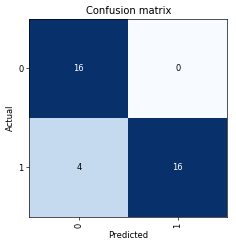

In [34]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

In [35]:
interp.most_confused(min_val=2)

[('1', '0', 4)]

In [36]:
learn.save('helicopters-1')

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.345058,0.497258,0.194444,00:12
1,0.347629,0.965326,0.277778,00:12


That actually didn't help. So loading back the original model.

In [39]:
learn.load('helicopters-1');

Here we're looking at whether we can do better by fine-tuning the learning rate. Jeremy says mainly you need to tinker with the learning rate and/or the epochs to get the best result. I'm still learning about the learning rate. :-)

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


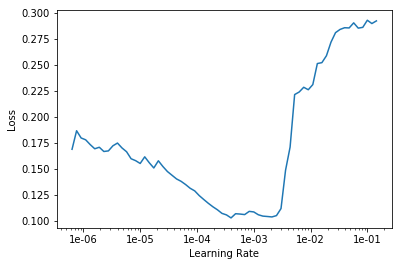

In [41]:
learn.recorder.plot()

In [42]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.164227,0.200703,0.055556,00:12
1,0.136653,0.207121,0.055556,00:12


In [43]:
# 94% accuracy! Save that! 

learn.save('helicopters-2')

In [46]:
learn.export()  #this creates a pickle file with all the info we need for the next steps

## Doing this in production

This actually comes from the second lesson, in which Jeremy talks about putting these models into production.

In [47]:
data.classes

['0', '1']

Production computers can use the model on a CPU -- without the need for a GPU. Also it's better that way. So here I tell the computer to use the CPU instead of the GPU

In [48]:
defaults.device = torch.device('cpu')  # for the gpu it would be 'cuda'

Now I grab a single, brand new image.

In [53]:
img = open_image('/home/ubuntu/data/newimages/N920PD2019-04-02_00_20_21.png')

In [ ]:
img

Here's that image:
![test image](notebook-images/image-3.png)

In [55]:
learn = load_learner(path)  # this gets the exported pickle file, which is stored in the image data path

In [56]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 1

"Category 1" is circling!